In [3]:
# Import the Hugging Face transformer tokenizer and model for sequence classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch  # PyTorch for deep learning operations
import scipy  # Scientific computing library

# Importing data manipulation and visualization libraries
import pandas as pd  # Pandas for handling structured data (DataFrames)
import matplotlib.pyplot as plt  # Matplotlib for data visualization


Simple Sentiment Analysis using a list of strings

In [4]:
# Define the sentiment analysis pipeline
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

# Example data
data = ["I love you", "I hate you"]

# Perform sentiment analysis
results = sentiment_pipeline(data)

# Print results
for text, result in zip(data, results):
    print(f"Text: {text}\nSentiment: {result['label']}, Score: {result['score']:.4f}\n")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Text: I love you
Sentiment: positive, Score: 0.8595

Text: I hate you
Sentiment: negative, Score: 0.7867



Sentiment Analysis on Dataframe and printing all scores

In [5]:
df = pd.read_csv('AAPL_articles.csv')

In [6]:
df

,Date,Title
0,2025-02-17,Apple's (AAPL) iPhone Sees Improved Shipment G...
1,2025-02-17,Apple (AAPL) Sees Improved iPhone Sales in Chi...
2,2025-02-17,Apple (AAPL) Plans to Enhance Vision Pro with ...
3,2025-02-17,Apple Integrates AI Technology Into Apple Visi...
4,2025-02-17,Apple's Next-Gen MacBook Pro with M5 Chip Expe...
...,...,...
1759,2023-01-04,7 Fun Facts About Apple Stock In 2022
1760,2023-01-04,Apple’s (AAPL) Stock Is Losing Its Shine After...
1761,2023-01-03,Apple's market cap falls under $2 trillion as ...
1762,2023-01-03,NASDAQ AAPL – Elliott Wave Projection


In [7]:
# Load the model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [9]:
# Define sentiment analysis function
def sentiment_analysis(text: str) -> tuple[float, float, float, str]:
    with torch.no_grad():  # Disable gradient computation for inference
        inputs = tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=512
        ).to(device)  # Move input tensors to the same device as the model
        
        outputs = model(**inputs)  # Get model predictions
        logits = outputs.logits  # Extract raw prediction scores (logits)

        # Convert logits to numpy array (on CPU) before applying softmax
        scores = {
            k: v
            for k, v in zip(
                model.config.id2label.values(),  # Get sentiment labels
                scipy.special.softmax(logits.cpu().numpy().squeeze(), axis=0)  # Move logits to CPU before processing
            )
        }

        return (
            scores["positive"],  # Probability of positive sentiment
            scores["negative"],  # Probability of negative sentiment
            scores["neutral"],  # Probability of neutral sentiment
            max(scores, key=scores.get)  # Sentiment label with the highest probability
        )


In [10]:
# Apply sentiment analysis to the 'Title' column
df[["positive_score", "negative_score", "neutral_score", "sentiment"]] = (
    df["Title"].apply(sentiment_analysis).apply(pd.Series)
)

In [11]:
# Compute a final sentiment score by subtracting negative sentiment probability from positive sentiment probability
df["score"] = df["positive_score"] - df["negative_score"]

In [12]:
df

,Date,Title,positive_score,negative_score,neutral_score,sentiment,score
0,2025-02-17,Apple's (AAPL) iPhone Sees Improved Shipment G...,0.799238,0.003745,0.197017,positive,0.795494
1,2025-02-17,Apple (AAPL) Sees Improved iPhone Sales in Chi...,0.832733,0.004285,0.162982,positive,0.828448
2,2025-02-17,Apple (AAPL) Plans to Enhance Vision Pro with ...,0.840967,0.002550,0.156483,positive,0.838416
3,2025-02-17,Apple Integrates AI Technology Into Apple Visi...,0.623318,0.004908,0.371774,positive,0.618410
4,2025-02-17,Apple's Next-Gen MacBook Pro with M5 Chip Expe...,0.596642,0.003863,0.399495,positive,0.592779
...,...,...,...,...,...,...,...
1759,2023-01-04,7 Fun Facts About Apple Stock In 2022,0.906020,0.002943,0.091037,positive,0.903077
1760,2023-01-04,Apple’s (AAPL) Stock Is Losing Its Shine After...,0.010366,0.876844,0.112790,negative,-0.866477
1761,2023-01-03,Apple's market cap falls under $2 trillion as ...,0.045483,0.459175,0.495342,neutral,-0.413692
1762,2023-01-03,NASDAQ AAPL – Elliott Wave Projection,0.176756,0.006645,0.816599,neutral,0.170112


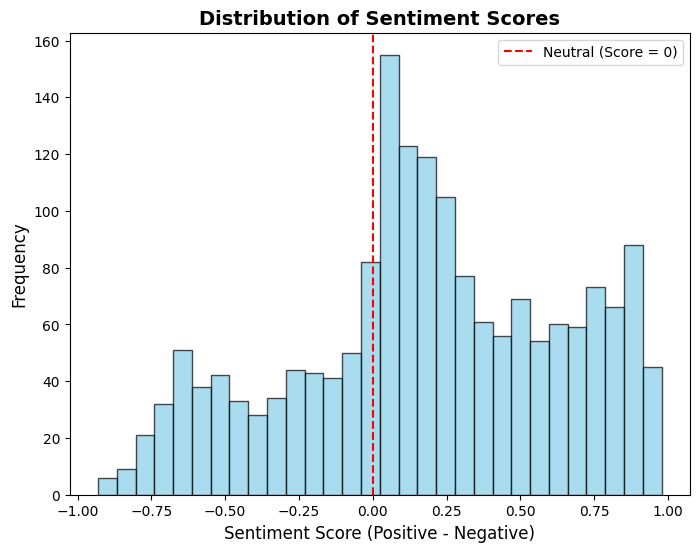

In [13]:
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the histogram of sentiment scores
plt.hist(df['score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add a title and labels
plt.title("Distribution of Sentiment Scores", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment Score (Positive - Negative)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add a vertical line at 0 to indicate the neutral sentiment threshold
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5, label="Neutral (Score = 0)")

# Add a legend
plt.legend()

# Show the plot
plt.show()
